In [1]:
using PyPlot

In [2]:
function MakeHexagon(Nx::Int)
      Npara=Nx^2;
      N=Npara*3;

      unit=transpose([cos(pi/6),sin(pi/6)])
      a=transpose([2*cos(π/6),0]);
      b=[cos(π/6),1+sin(π/6)];
      bM=transpose(repeat(b,outer=[1,Nx]))
      rotmat=[[cos(2*π/3) -sin(2*π/3)]
            [sin(2*π/3) cos(2*π/3)]]


      Xb=Array{Float64}(N,2);
      Xw=Array{Float64}(N,2);

      ## Creating the positions in the first parallelogram
      for i in 1:Nx
        Xb[i,:]=(i-1)*a;
        Xw[i,:]=unit+(i-1)*a;
      end

      for j in 2:Nx
        Xb[(Nx*(j-1)+1):(Nx*(j-1)+Nx),:]=Xb[1:Nx,:]+(j-1)*bM;
        Xw[(Nx*(j-1)+1):(Nx*(j-1)+Nx),:]=Xw[1:Nx,:]+(j-1)*bM;
      end

      subt=Xb[Npara,2]+1
      Xb[1:Npara,1]=Xb[1:Npara,1]-(Nx-1)*b[1];
      Xw[1:Npara,1]=Xw[1:Npara,1]-(Nx-1)*b[1];
      Xb[1:Npara,2]=Xb[1:Npara,2]-subt;
      Xw[1:Npara,2]=Xw[1:Npara,2]-subt;

      Xb[Npara+(1:Npara),1]=rotmat[1,1]*Xb[1:Npara,1]+rotmat[1,2]*Xb[1:Npara,2];
      Xw[Npara+(1:Npara),1]=rotmat[1,1]*Xw[1:Npara,1]+rotmat[1,2]*Xw[1:Npara,2];
      Xb[Npara+(1:Npara),2]=rotmat[2,1]*Xb[1:Npara,1]+rotmat[2,2]*Xb[1:Npara,2];
      Xw[Npara+(1:Npara),2]=rotmat[2,1]*Xw[1:Npara,1]+rotmat[2,2]*Xw[1:Npara,2];

      Xb[2*Npara+(1:Npara),1]=rotmat[1,1]*Xb[Npara+(1:Npara),1]+rotmat[1,2]*Xb[Npara+(1:Npara),2];
      Xw[2*Npara+(1:Npara),1]=rotmat[1,1]*Xw[Npara+(1:Npara),1]+rotmat[1,2]*Xw[Npara+(1:Npara),2];
      Xb[2*Npara+(1:Npara),2]=rotmat[2,1]*Xb[Npara+(1:Npara),1]+rotmat[2,2]*Xb[Npara+(1:Npara),2];
      Xw[2*Npara+(1:Npara),2]=rotmat[2,1]*Xw[Npara+(1:Npara),1]+rotmat[2,2]*Xw[Npara+(1:Npara),2];

      vb=sortperm(Xb[:,1]+Npara*Xb[:,2])
      vw=sortperm(Xw[:,1]+Npara*Xw[:,2])
      Xb=Xb[vb,:];
      Xw=Xw[vw,:];

  return Xb, Xw
end


MakeHexagon (generic function with 1 method)

In [3]:
function MakeBonds(Nx::Int,Xb::Array{Float64,2},Xw::Array{Float64,2})
  Npara=Nx^2;
  N=Npara*3;

  nrowb=[collect(Nx:(2*Nx));collect((2*Nx-1):-1:(Nx+1))]
  nroww=flipdim(nrowb,1)

  i0b=ones(nrowb)
  i0w=ones(nroww)
  for i in 2:length(nrowb)
      i0b[i]=i0b[i-1]+nrowb[i-1]
      i0w[i]=i0w[i-1]+nroww[i-1]
  end
  push!(i0b,N+1);
  push!(i0w,N+1);

  offsetb=zeros(N+1)
  offsetw=zeros(N+1)
  for i in 1:Nx
      offsetb[i0b[i]:i0b[i+1]]=i-1
      offsetb[i0b[i+Nx]:i0b[i+1+Nx]]=Nx-i
      offsetw[i0w[i]:i0w[i+1]]=i-1
      offsetw[i0w[i+Nx]:i0w[i+1+Nx]]=Nx-i
  end

  Bondsw=Array{Int64}(N,3);
  Bondsb=Array{Int64}(N,3);
  for i in 1:N
      Bondsb[i,2]=i+offsetb[i];
      Bondsw[i,2]=i-offsetw[i];
      Bondsb[i,1]=i+1+offsetb[i];
      Bondsw[i,1]=i-1-offsetw[i];
      Bondsb[i,3]=i-Nx;
      Bondsw[i,3]=i+Nx;
  end

  boundaryb=ones(Int64,N,3);
  boundaryw=ones(Int64,N,3);
  i=1
  while isapprox(Xb[1,2],Xb[i,2])
      Bondsb[i,3]=N-Nx+i
      boundaryb[i,3]=0
      Bondsw[N-Nx+i,3]=i
      boundaryw[N-Nx+i,3]=0
      #println(N-Nx+i,' ',i)
      i+=1
  end

  Bondsw[i0w[1:Nx],1]=i0b[Nx+1+(1:Nx)]-1;
  boundaryw[i0w[1:Nx],1]=0
  Bondsb[i0b[Nx+1+(1:Nx)]-1,1]=i0w[1:Nx];
  boundaryb[i0b[Nx+1+(1:Nx)]-1,1]=0

  Bondsw[i0w[1+(1:Nx)]-1,2]=i0b[Nx+(1:Nx)];
  boundaryw[i0w[1+(1:Nx)]-1,2]=0
  Bondsb[i0b[Nx+(1:Nx)],2]=i0w[1+(1:Nx)]-1;
  boundaryb[i0b[Nx+(1:Nx)],2]=0

  return Bondsb, Bondsw, boundaryb, boundaryw
end


MakeBonds (generic function with 1 method)

In [4]:
function U(x::Float64,y::Float64)
    return [2x*y, x^2-y^2]
end

U (generic function with 1 method)

In [5]:
function delta(i::Int,j::Int)
    Ri=transpose(Xw[i,:])[:,1];
    nei=Bondsw[i,j];
    
    Rj=transpose(Xb[nei,:])[:,1];
    Ui=U(Xw[i,1],Xw[i,2]);
    
    Uj=U(Xb[nei,1],Xb[nei,2]);
    
    return Ri+Ui-Rj-Uj;
end

delta (generic function with 1 method)

Jij (generic function with 1 method)

In [38]:
Nx=10;
N=3*Nx^2;
Xb,Xw=MakeHexagon(Nx);
Bondsb, Bondsw, bb, bw= MakeBonds(Nx,Xb,Xw);

In [49]:
Jstrain=zeros(Float64,N,3);
for i in 1:N
    for j in 1:3
        Jstrain[i,j]=Jij(i,j,.001)
    end
end
nJstrain=(Jstrain-minimum(Jstrain))/maximum(Jstrain-minimum(Jstrain));

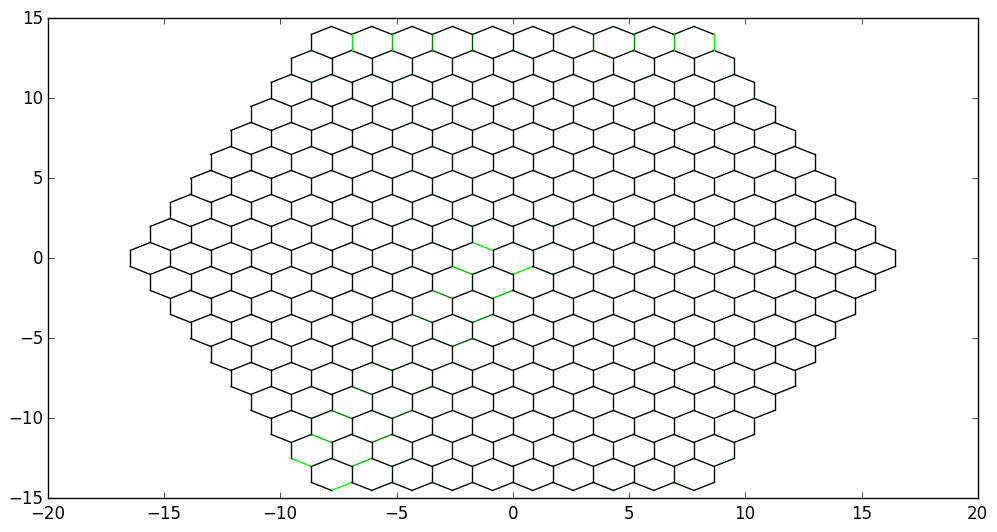

In [50]:
if true
    w, h = plt[:figaspect](.5)
    figure(figsize=(w,h))
    for i in 1:N
        #println(Xb[i,1],' ',Bondsb[i,1])
        xx=[Xb[i,1]*bb[i,1], Xw[Bondsb[i,1],1]*bb[i,1] ]
        yx=[Xb[i,2]*bb[i,1], Xw[Bondsb[i,1],2]*bb[i,1] ]
        plot(xx,yx,color=[0,1-nJstrain[i,1],0])
            
        xx=[Xb[i,1]*bb[i,2], Xw[Bondsb[i,2],1]*bb[i,2] ]
        yx=[Xb[i,2]*bb[i,2], Xw[Bondsb[i,2],2]*bb[i,2] ]
        plot(xx,yx,color=[0,1-nJstrain[i,2],0])
    
        #println(i,' ',Bonds[i,3])
        xx=[Xb[i,1]*bb[i,3], Xw[Bondsb[i,3],1]*bb[i,3] ]
        yx=[Xb[i,2]*bb[i,3], Xw[Bondsb[i,3],2]*bb[i,3] ]
        plot(xx,yx,color=[0,1-nJstrain[i,3],0])
    end
    
    #scatter(Xb[:,1],Xb[:,2])
    #scatter(Xw[:,1],Xw[:,2])
    
    #quiver(Xw[:,1],Xw[:,2],Uiw[:,1],Uiw[:,2])
    #quiver(Xb[:,1],Xb[:,2],Uib[:,1],Uib[:,2])
end

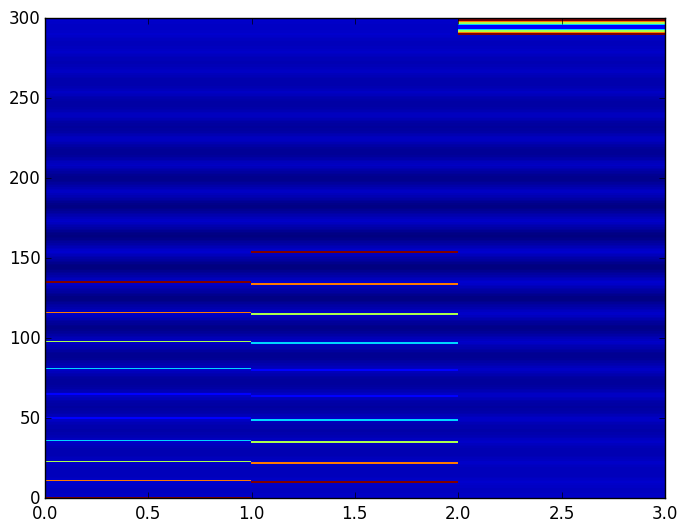

PyObject <matplotlib.collections.PolyCollection object at 0x329265d50>

In [67]:
pcolor(diw)

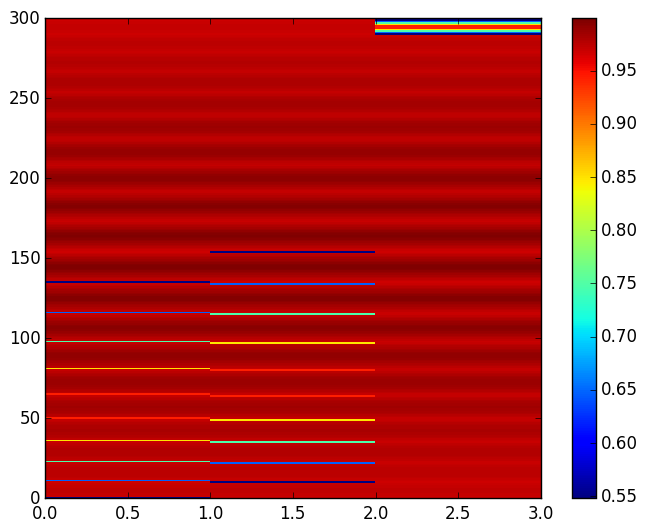

PyObject <matplotlib.colorbar.Colorbar instance at 0x329831248>

In [68]:
pcolor(Jstrain)
colorbar()

In [41]:
Uiwn=zeros(Float64,N);
Uibn=zeros(Float64,N);
Uiw=zeros(Float64,N,2);
Uib=zeros(Float64,N,2);
for i in 1:N
    Uiw[i,:]=U(Xw[i,1],Xw[i,2]);
    Uib[i,:]=U(Xb[i,1],Xb[i,2]);
    
    Uiwn[i]=norm(U(Xw[i,1],Xw[i,2]));
    Uibn[i]=norm(U(Xb[i,1],Xb[i,2]));
end

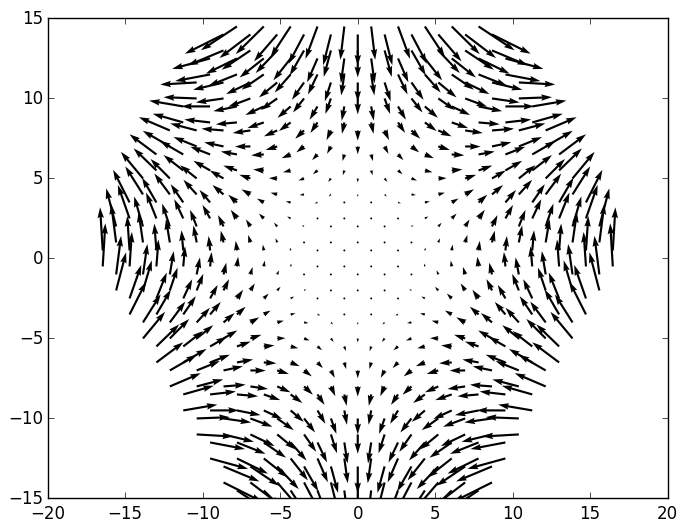

PyObject <matplotlib.quiver.Quiver object at 0x3262f2190>

In [51]:
quiver(Xw[:,1],Xw[:,2],Uiw[:,1],Uiw[:,2])
quiver(Xb[:,1],Xb[:,2],Uib[:,1],Uib[:,2])


In [42]:
Xwp=Xw+Uiw;
Xbp=Xb+Uib;

In [57]:
diw=zeros(Float64,N,3);
dib=zeros(Float64,N,3);
for i in 1:N
    for j in 1:3
        diw[i,j]=norm(delta(i,j));
        dib[i,j]=norm(delta(i,j));
    end
end
diwn=(diw-minimum(diw))/(maximum(diw-minimum(diw)));
dibn=(dib-minimum(dib))/(maximum(dib-minimum(dib)));

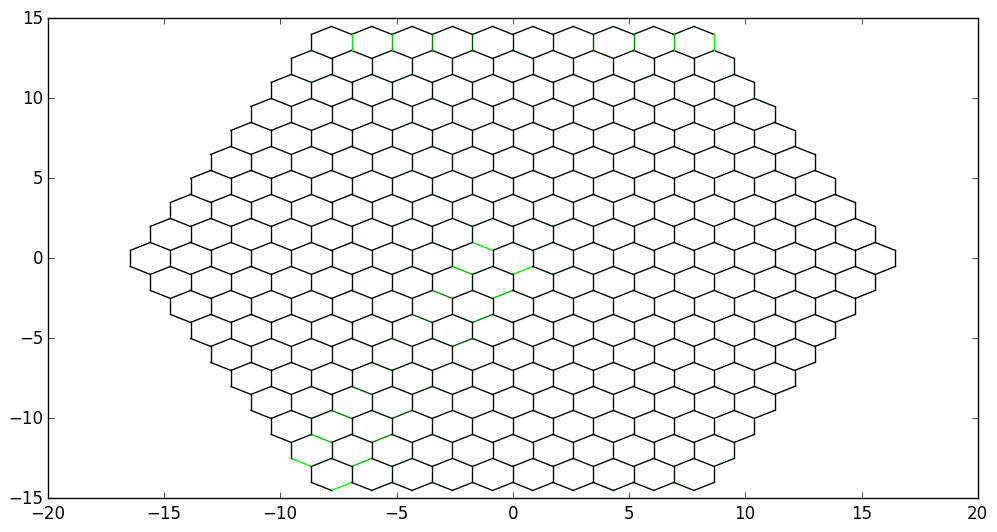

In [66]:
if true
    w, h = plt[:figaspect](.5)
    figure(figsize=(w,h))
    for i in 1:N
        #println(Xb[i,1],' ',Bondsb[i,1])
        xx=[Xb[i,1]*bb[i,1], Xw[Bondsb[i,1],1]*bb[i,1] ]
        yx=[Xb[i,2]*bb[i,1], Xw[Bondsb[i,1],2]*bb[i,1] ]
        plot(xx,yx,color=[0;diwn[i,1];0])
            
        xx=[Xb[i,1]*bb[i,2], Xw[Bondsb[i,2],1]*bb[i,2] ]
        yx=[Xb[i,2]*bb[i,2], Xw[Bondsb[i,2],2]*bb[i,2] ]
        plot(xx,yx,color=[0;diwn[i,2];0])
    
        #println(i,' ',Bonds[i,3])
        xx=[Xb[i,1]*bb[i,3], Xw[Bondsb[i,3],1]*bb[i,3] ]
        yx=[Xb[i,2]*bb[i,3], Xw[Bondsb[i,3],2]*bb[i,3] ]
        plot(xx,yx,color=[0;diwn[i,3];0])
    end
end